In [502]:
import psycopg2 as pc2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
import json
import keras

In [3]:
conn = pc2.connect(host = "dtc-db-3",
                   database = "mailmonitor",
                   port = 5432,
                   user='readonly',
                   password='readonly')

In [4]:
query = "select subject, folder_name,processed_at from messages"
df = pd.read_sql(query, conn)
df['year'] = pd.DatetimeIndex(df['processed_at']).year
#df['Year'] = pd.to_datetime(df["year"], format = "%Y")
#df.set_index('year',inplace=True)
df.drop('processed_at',axis=1,inplace=True)
df

,subject,folder_name,year
0,"Fri, 24 Apr 2015 03:21:56 -0700",Spam,2015
1,"Fri, 24 Apr 2015 03:21:56 -0700",Spam,2015
2,State’s Deepest Darkest Secret: a $54 Trillion...,Inbox,2015
3,You Can Win an AR-15!,Inbox,2015
4,⚠ Breaking News! Obama’s Amnesty Executive Ord...,Inbox,2015
...,...,...,...
365514,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021
365515,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021
365516,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021
365517,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021


In [5]:
df[df.folder_name=='Spam'].value_counts()

subject                                                                       folder_name  year
Parker - DoBizLo Daily Deals                                                  Spam         2015    92
Central Denver : Explore The Community                                        Spam         2017    73
Your Purchase from Audi Denver Grants You Exclusive Access to Traveland Golf  Spam         2018    67
It's September's Featured Roll or Bowl                                        Spam         2018    66
Support The Children + Get Your Daily Features                                Spam         2018    54
                                                                                                   ..
Looking to Make a Statement? Look no Further.                                 Spam         2018     1
Lookout For Smashing Pumpkins + $2000 Off A 2019 Logan Crossfire              Spam         2018     1
Love is in the Air... Enjoy 1.9% APR for 60 Months                            Spam      

In [468]:
dff = df.copy()

In [469]:
dff['folder'] = dff['folder_name']
dff.loc[dff.folder == 'INBOX', 'folder'] = 0
dff.loc[dff.folder == 'Inbox', 'folder'] = 0
dff.loc[dff.folder != 0,'folder'] = 1
dff

,subject,folder_name,year,folder
0,"Fri, 24 Apr 2015 03:21:56 -0700",Spam,2015,1
1,"Fri, 24 Apr 2015 03:21:56 -0700",Spam,2015,1
2,State’s Deepest Darkest Secret: a $54 Trillion...,Inbox,2015,0
3,You Can Win an AR-15!,Inbox,2015,0
4,⚠ Breaking News! Obama’s Amnesty Executive Ord...,Inbox,2015,0
...,...,...,...,...
365514,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021,0
365515,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021,0
365516,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021,0
365517,The Pikes Peak Cog Railway Is Reopening This S...,INBOX,2021,0


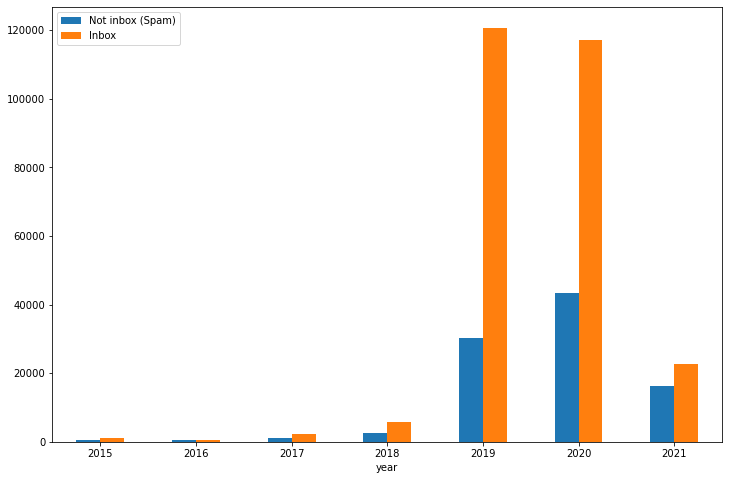

In [95]:
#fig, ax = plt.subplots()
df_gb = dff.groupby(['year', 'folder']).size().unstack(level=1)
df_gb.plot(kind = 'bar',figsize=(12,8),rot=0)
plt.legend(['Not inbox (Spam)','Inbox'])

In [470]:
# training set 273519, testing set 91174
train, test = train_test_split(dff, shuffle=True)

In [471]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [472]:
train.subject = train.subject.str.replace('\W', ' ')

C:\Users\yluo\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
'''
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001F911"
        
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

import string


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

'''

'\ndef remove_URL(text):\n    url = re.compile(r"https?://\\S+|www\\.\\S+")\n    return url.sub(r"", text)\n\n\ndef remove_html(text):\n    html = re.compile(r"<.*?>")\n    return html.sub(r"", text)\n\ndef remove_emoji(string):\n    emoji_pattern = re.compile(\n        "["\n        u"😀-🙏"  # emoticons\n        u"🌀-🗿"  # symbols & pictographs\n        u"🚀-\U0001f6ff"  # transport & map symbols\n        u"\U0001f1e0-🇿"  # flags (iOS)\n        u"✂-➰"\n        u"Ⓜ-🉑"\n        u"🤑"\n        \n        "]+",\n        flags=re.UNICODE,\n    )\n    return emoji_pattern.sub(r"", string)\n\nimport string\n\n\ndef remove_punct(text):\n    table = str.maketrans("", "", string.punctuation)\n    return text.translate(table)\n\n'

In [12]:
'''
train.subject = train.subject.map(lambda x: remove_URL(x))
train.subject = train.subject.map(lambda x: remove_html(x))
train.subject = train.subject.map(lambda x: remove_emoji(x))
train.subject = train.subject.map(lambda x: remove_punct(x))
'''

'\ntrain.subject = train.subject.map(lambda x: remove_URL(x))\ntrain.subject = train.subject.map(lambda x: remove_html(x))\ntrain.subject = train.subject.map(lambda x: remove_emoji(x))\ntrain.subject = train.subject.map(lambda x: remove_punct(x))\n'

In [473]:
train.head(1)

,subject,folder_name,year,folder
0,6 Low Carb Cocktails for Warm Weather Drinking,INBOX,2020,0


In [16]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yluo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yluo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [474]:


stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [475]:
train.subject = train.subject.map(remove_stopwords)
train.head(5)

C:\Users\yluo\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,subject,folder_name,year,folder
0,6 low carb cocktails warm weather drinking,INBOX,2020,0
1,behind polls republicans see silver lining vot...,INBOX,2020,0
2,huge update gop cowards reversing course sidin...,INBOX,2020,0
3,kentucky derby run 23 000 fans stands,[Gmail]/Spam,2020,1
4,gift better brcc bundles,INBOX,2019,0


In [476]:

import nltk
def create_corpus_tk(df):
    corpus = []
    for text in train.subject:
        words = [word.lower() for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

In [477]:
corpus = create_corpus_tk(train.subject)

In [478]:
corpus[0]

['6', 'low', 'carb', 'cocktails', 'warm', 'weather', 'drinking']

In [479]:
num_words = len(corpus)
print(num_words)

274139


In [464]:
len(train.subject)

274139

In [480]:
train.subject

0                6 low carb cocktails warm weather drinking
1         behind polls republicans see silver lining vot...
2         huge update gop cowards reversing course sidin...
3                     kentucky derby run 23 000 fans stands
4                                  gift better brcc bundles
                                ...                        
274134                     survive colorado lightning storm
274135    breaking news deep state caught destroying cli...
274136    breaking backstabbing gop advancing amnesty co...
274137                            freedom firearm month dcf
274138                                     12 000 msrp 1 27
Name: subject, Length: 274139, dtype: object

In [493]:
train.to_csv('train_subject.csv',index=False)

In [481]:
train_size = int(train.shape[0] * 0.8)

train_sentences = train.subject[:train_size]
train_labels = train.folder[:train_size]

test_sentences = train.subject[train_size:]
test_labels = train.folder[train_size:]

In [482]:


max_len = 50

In [494]:
train_sentence = pd.read_csv('train_subject.csv')

In [498]:
train_sentence.subject.astype(str)

0                6 low carb cocktails warm weather drinking
1         behind polls republicans see silver lining vot...
2         huge update gop cowards reversing course sidin...
3                     kentucky derby run 23 000 fans stands
4                                  gift better brcc bundles
                                ...                        
274134                     survive colorado lightning storm
274135    breaking news deep state caught destroying cli...
274136    breaking backstabbing gop advancing amnesty co...
274137                            freedom firearm month dcf
274138                                     12 000 msrp 1 27
Name: subject, Length: 274139, dtype: object

In [491]:
train.subject

0                6 low carb cocktails warm weather drinking
1         behind polls republicans see silver lining vot...
2         huge update gop cowards reversing course sidin...
3                     kentucky derby run 23 000 fans stands
4                                  gift better brcc bundles
                                ...                        
274134                     survive colorado lightning storm
274135    breaking news deep state caught destroying cli...
274136    breaking backstabbing gop advancing amnesty co...
274137                            freedom firearm month dcf
274138                                     12 000 msrp 1 27
Name: subject, Length: 274139, dtype: object

In [484]:
train_sentences

0                6 low carb cocktails warm weather drinking
1         behind polls republicans see silver lining vot...
2         huge update gop cowards reversing course sidin...
3                     kentucky derby run 23 000 fans stands
4                                  gift better brcc bundles
                                ...                        
219306                devo selling iconic whip face shields
219307    good news denver christkindl market returns ho...
219308      documentary takes new look jonbenét ramsey case
219309    happening today congress voting radical gun co...
219310                             golden girls cruise 2021
Name: subject, Length: 219311, dtype: object

In [499]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentence.subject.astype(str))

In [29]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [30]:
train.subject[0]

'adrenaline pumping adventures using aed'

In [31]:
train_sequences[0]

[5193, 5194, 4219, 915, 5195]

In [99]:
train_padded

array([[5193, 5194, 4219, ...,    0,    0,    0],
       [ 154,   49,  641, ...,    0,    0,    0],
       [ 112,   32, 1922, ...,    0,    0,    0],
       ...,
       [3160,  479, 2019, ...,    0,    0,    0],
       [1284, 3531,  760, ...,    0,    0,    0],
       [ 140, 1316, 1460, ...,    0,    0,    0]])

In [32]:
train_padded = pad_sequences(
    train_sequences, maxlen=max_len, truncating="post", padding="post"
)

In [33]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

In [34]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 9632


In [35]:
word_index

{'breaking': 1,
 'colorado': 2,
 'day': 3,
 'denver': 4,
 'new': 5,
 'fec': 6,
 'meeting': 7,
 'trump': 8,
 'get': 9,
 '10': 10,
 'gop': 11,
 'dems': 12,
 'gun': 13,
 'best': 14,
 'united': 15,
 '2020': 16,
 'save': 17,
 'training': 18,
 'free': 19,
 'bighorn': 20,
 'sale': 21,
 'zoom': 22,
 'bill': 23,
 '20': 24,
 'tonight': 25,
 'pelosi': 26,
 'dcf': 27,
 'weekend': 28,
 'covid': 29,
 'control': 30,
 'uadf': 31,
 'us': 32,
 'coffee': 33,
 '1': 34,
 'pillar': 35,
 'week': 36,
 'border': 37,
 'ford': 38,
 'automotive': 39,
 'reminder': 40,
 'family': 41,
 'democrats': 42,
 '19': 43,
 'first': 44,
 'friday': 45,
 'night': 46,
 'cold': 47,
 'savings': 48,
 'coming': 49,
 '11': 50,
 'help': 51,
 'black': 52,
 '3': 53,
 '5': 54,
 'back': 55,
 'bell': 56,
 'special': 57,
 '2': 58,
 'weekly': 59,
 'month': 60,
 'year': 61,
 'test': 62,
 'beyer': 63,
 'members': 64,
 'stone': 65,
 'service': 66,
 'brcc': 67,
 'vote': 68,
 'tier': 69,
 '7': 70,
 'christmas': 71,
 'one': 72,
 'time': 73,
 'volv

In [148]:
word_index['adrenaline']

5193

In [37]:
embedding_dict = {}
with open("glove.6B.100d.txt", "r",encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [39]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [162]:
train_padded[0][0]

5193

In [158]:
train_padded

array([[5193, 5194, 4219, ...,    0,    0,    0],
       [ 154,   49,  641, ...,    0,    0,    0],
       [ 112,   32, 1922, ...,    0,    0,    0],
       ...,
       [3160,  479, 2019, ...,    0,    0,    0],
       [1284, 3531,  760, ...,    0,    0,    0],
       [ 140, 1316, 1460, ...,    0,    0,    0]])

In [160]:
embedding_matrix[5193]

array([ 0.62901002, -0.30140001,  0.77780998, -1.98380005,  0.038554  ,
        0.50762999, -0.28997001,  0.65205997, -0.23244999,  0.032924  ,
        0.80843002,  0.18978   , -0.86848003, -0.71749997,  0.15676001,
        0.47859001, -1.1552    , -0.19176   ,  0.24688999,  0.19354001,
       -0.21999   , -0.23321   , -0.66030997, -0.59073001,  0.037053  ,
        1.07089996, -0.076202  , -0.0099041 ,  0.83186001,  0.067971  ,
       -0.29822999, -0.23772   , -0.28952   ,  0.54076999,  0.097979  ,
       -0.61172003, -0.80361003,  0.74010998,  0.25652999,  0.1125    ,
        0.32157001,  0.35018   , -0.69138998, -0.42442   ,  0.10353   ,
        0.21898   ,  0.19842   , -0.73926997,  0.64432001, -0.63586998,
       -0.85430998,  0.20467   ,  0.31986001, -0.035938  ,  0.39096001,
       -0.66526997, -0.16761   , -0.092277  ,  0.32077   , -0.052522  ,
        0.87300003,  0.31332999, -0.031438  ,  0.20269001, -0.15072   ,
        0.63875997,  0.90921998, -1.33529997,  0.31687   , -0.64

In [161]:
embedding_dict.get("adrenaline")

array([ 0.62901  , -0.3014   ,  0.77781  , -1.9838   ,  0.038554 ,
        0.50763  , -0.28997  ,  0.65206  , -0.23245  ,  0.032924 ,
        0.80843  ,  0.18978  , -0.86848  , -0.7175   ,  0.15676  ,
        0.47859  , -1.1552   , -0.19176  ,  0.24689  ,  0.19354  ,
       -0.21999  , -0.23321  , -0.66031  , -0.59073  ,  0.037053 ,
        1.0709   , -0.076202 , -0.0099041,  0.83186  ,  0.067971 ,
       -0.29823  , -0.23772  , -0.28952  ,  0.54077  ,  0.097979 ,
       -0.61172  , -0.80361  ,  0.74011  ,  0.25653  ,  0.1125   ,
        0.32157  ,  0.35018  , -0.69139  , -0.42442  ,  0.10353  ,
        0.21898  ,  0.19842  , -0.73927  ,  0.64432  , -0.63587  ,
       -0.85431  ,  0.20467  ,  0.31986  , -0.035938 ,  0.39096  ,
       -0.66527  , -0.16761  , -0.092277 ,  0.32077  , -0.052522 ,
        0.873    ,  0.31333  , -0.031438 ,  0.20269  , -0.15072  ,
        0.63876  ,  0.90922  , -1.3353   ,  0.31687  , -0.64938  ,
        0.75536  , -0.78434  ,  0.66269  ,  0.44178  , -0.4736

In [155]:
num_words

9633

In [157]:
word_index["humor"]

3272

In [42]:
embedding_dict.get("humor")

array([ 0.12102  ,  0.15919  ,  0.57651  , -0.64885  , -0.018114 ,
        0.81705  , -0.20923  , -0.4013   , -0.26703  ,  0.45778  ,
       -0.68631  , -0.35044  , -0.13487  , -0.0058998,  0.44537  ,
        0.6458   , -0.49616  , -0.33951  , -0.26207  ,  0.41948  ,
        0.80614  , -0.13352  , -0.65547  , -1.0535   ,  0.4554   ,
        0.70436  , -0.04756  , -0.041788 , -0.36993  , -0.44544  ,
       -0.17457  ,  0.46704  , -1.2787   , -0.2036   ,  0.26769  ,
        0.22095  , -0.072417 , -0.08944  , -0.41842  ,  0.31555  ,
        0.47776  , -0.096983 , -1.0555   , -0.51882  , -0.50685  ,
       -0.09724  ,  0.051038 , -0.31864  ,  0.41282  , -0.49141  ,
        0.11218  ,  0.17831  ,  0.37976  ,  0.97001  ,  0.073411 ,
       -1.54     ,  0.069392 , -0.29664  ,  0.076152 , -0.39628  ,
        0.85271  ,  1.0843   , -0.093598 , -0.82453  ,  0.76908  ,
       -0.32088  ,  1.8475   , -0.83703  ,  0.29144  , -0.14991  ,
        0.11909  ,  0.72146  ,  0.42551  ,  0.3858   , -0.0071

In [44]:
print(train_padded.shape)
print(train_labels.shape)

(219311, 50)
(219311,)


In [46]:
train_labels.sum()

56666

In [47]:
56666/218814

0.2589688045554672

#### Baseline Model with GloVe

In [127]:

model = Sequential()

embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_len,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [258]:
num_words

9633

In [191]:
len(embedding_layer.get_weights()[0])

9633

In [259]:
embedding_layer.get_weights()

[array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.41259  , -0.31065  ,  0.29951  , ...,  0.0090597,  0.4888   ,
          0.33219  ],
        [ 0.20024  , -0.15213  ,  0.75959  , ...,  0.50671  ,  0.61645  ,
         -0.24715  ],
        ...,
        [-0.015913 , -0.30256  , -0.026587 , ...,  0.30884  , -0.39604  ,
         -0.021601 ],
        [ 0.012833 ,  0.31163  , -0.27999  , ...,  0.2169   , -0.36248  ,
          0.079934 ],
        [-0.25443  , -0.51396  ,  0.54856  , ...,  0.019298 , -0.20062  ,
          0.2041   ]], dtype=float32)]

In [139]:
embedding_layer.get_weights()[0][1]

array([ 0.41259  , -0.31065  ,  0.29951  ,  0.36721  ,  0.13741  ,
        0.55248  , -0.31164  , -0.0087347, -0.18458  , -0.047201 ,
        0.36065  , -0.12249  ,  0.20574  ,  0.30119  , -0.23471  ,
        0.13276  , -0.33065  ,  0.14375  , -0.071672 , -0.085993 ,
        0.31045  ,  0.37707  ,  0.55549  , -0.086976 ,  1.2369   ,
        0.35397  , -0.76141  , -0.47132  ,  0.47715  ,  0.023182 ,
        0.027953 ,  0.32094  ,  0.1566   , -0.28748  , -0.1149   ,
       -1.047    , -0.39054  , -0.63109  , -0.38466  ,  0.40104  ,
       -0.22523  , -0.093672 ,  0.22211  ,  0.21125  ,  0.10776  ,
       -0.12398  , -0.030252 , -0.37765  , -0.036319 , -0.87442  ,
        0.73861  ,  0.11461  ,  0.012238 ,  1.0808   ,  0.10115  ,
       -1.9685   ,  0.10829  ,  0.5701   ,  1.3935   ,  1.1848   ,
       -0.2129   ,  0.25336  , -0.35452  ,  0.15792  , -0.15401  ,
        0.3987   ,  0.64375  ,  0.020352 ,  0.18372  , -0.44399  ,
       -0.25399  ,  0.47873  , -0.23172  , -0.061468 , -0.0661

In [49]:
history = model.fit(
    train_padded,
    train_labels.astype('int'),
    epochs=30,
    validation_data=(test_padded, test_labels.astype('int')),
    verbose=1,
)

Epoch 1/30
6854/6854 [==============================] - 106s 15ms/step - loss: 0.5526 - accuracy: 0.7449 - val_loss: 0.5095 - val_accuracy: 0.7591
Epoch 2/30
6854/6854 [==============================] - 103s 15ms/step - loss: 0.5059 - accuracy: 0.7608 - val_loss: 0.4787 - val_accuracy: 0.7670
Epoch 3/30
6854/6854 [==============================] - 105s 15ms/step - loss: 0.4794 - accuracy: 0.7701 - val_loss: 0.4615 - val_accuracy: 0.7727
Epoch 4/30
6854/6854 [==============================] - 105s 15ms/step - loss: 0.4615 - accuracy: 0.7762 - val_loss: 0.4509 - val_accuracy: 0.7772
Epoch 5/30
6854/6854 [==============================] - 105s 15ms/step - loss: 0.4529 - accuracy: 0.7784 - val_loss: 0.4495 - val_accuracy: 0.7752
Epoch 6/30
6854/6854 [==============================] - 106s 15ms/step - loss: 0.4478 - accuracy: 0.7800 - val_loss: 0.4462 - val_accuracy: 0.7795
Epoch 7/30
6854/6854 [==============================] - 105s 15ms/step - loss: 0.4443 - accuracy: 0.7814 - val_loss: 0

In [452]:
model.save("EmailClassification.h5")

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [50]:
sequences = tokenizer.texts_to_sequences(test.subject)
padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [51]:
pred = model.predict(padded)
pred_int = pred.round().astype("int")

In [55]:
test.subject[7398]

'Bighorn Automotive  Has A Great Oil Change  Special'

In [57]:
sequences = tokenizer.texts_to_sequences(pd.Series("Come enjoy Corned Beef and Cabbage with us this St. Patrick's Day."))
padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
pred = model.predict(padded)
pred.round().astype("int")

array([[0]])

#### Function

In [358]:
# JSON statement
s ='''{
  "subjects": [
    {
      "subject": "Exclusive Access to Traveland Golf"
    },
    {
      "subject": "Business School"
    },
    {
      "subject": "TEST Get The Black Rifle Essentials"
    }]
      }'''

In [359]:
import json
subjects = json.loads(s)

In [360]:
subjects

{'subjects': [{'subject': 'Exclusive Access to Traveland Golf'},
  {'subject': 'Business School'},
  {'subject': 'TEST Get The Black Rifle Essentials'}]}

In [361]:
for sub in subjects['subjects']:
    print(sub['subject'])

Exclusive Access to Traveland Golf
Business School
TEST Get The Black Rifle Essentials


In [365]:
for sub in subjects['subjects']:
    sub['folder']='a'
    print(sub)

{'subject': 'Exclusive Access to Traveland Golf', 'folder': 'a'}
{'subject': 'Business School', 'folder': 'a'}
{'subject': 'TEST Get The Black Rifle Essentials', 'folder': 'a'}


In [336]:
# subject can be list/string here
def folder_prediction(subject):
    model = keras.models.load_model("PostCategory.h5")
    df = pd.DataFrame(columns=['Subject','Folder'])
    for sub in subject:
        sequences = tokenizer.texts_to_sequences(pd.Series(sub))
        padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
        pred = model.predict(padded)
        prediction = pred.round().astype("int")
        if prediction[0][0] == 0:
            df = df.append({'Subject':sub,'Folder':'Inbox'}, ignore_index=True)
        else:
            df = df.append({'Subject':sub,'Folder':'Spam'}, ignore_index=True)
    return df


In [ ]:
# JSON API

In [447]:
# JSON statement
import json
s ='''{"subjects": 
 [{"subject": "Exclusive Access to Traveland Golf"},
  {"subject": "Business School"},
  {"subject": "TEST Get The Black Rifle Essentials"}]}'''

In [443]:
def load_json(json_file):
    subject_list = []
    subjects = json.loads(json_file)
    for sub in subjects['subjects']:
        subject_list.append(sub['subject'])
    return subjects['subjects'], subject_list

In [454]:
a,b = load_json(s)
a

[{'subject': 'Exclusive Access to Traveland Golf'},
 {'subject': 'Business School'},
 {'subject': 'TEST Get The Black Rifle Essentials'}]

In [444]:
# subject can be list/string here
def folder_prediction(subject):
    json_dict = subject[0]
    subject_list = subject[1]
    folder = []
    for i,sub in enumerate(subject_list):
        sequences = tokenizer.texts_to_sequences(pd.Series(sub))
        padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
        pred = model.predict(padded)
        prediction = pred.round().astype("int")
        if prediction[0][0] == 0:
            json_dict[i]['folder'] = 'Inbox'
        else:
            json_dict[i]['folder'] =  'Spam'
    return json_dict

In [445]:
def dump_json(json_file):
    subjects = json.loads(json_file)
    subjects['subjects'] = folder_prediction(load_json(s))
    print(json.dumps(subjects, indent=2))

In [450]:
dump_json(s)

{
  "subjects": [
    {
      "subject": "Exclusive Access to Traveland Golf",
      "folder": "Spam"
    },
    {
      "subject": "Business School",
      "folder": "Inbox"
    },
    {
      "subject": "TEST Get The Black Rifle Essentials",
      "folder": "Spam"
    }
  ]
}


In [337]:
folder_prediction(['Exclusive Access to Traveland Golf','Business School','TEST Get The Black Rifle Essentials'])

,Subject,Folder
0,Exclusive Access to Traveland Golf,Spam
1,Business School,Inbox
2,TEST Get The Black Rifle Essentials,Spam


In [316]:
# Subject inbox/spam prediction
def inbox_prediction(subject):
    sequences = tokenizer.texts_to_sequences(pd.Series(subject))
    padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    pred = model.predict(padded)
    prediction = pred.round().astype("int")
    if prediction[0][0] == 0:
        return 'Inbox'
    else:
        return 'Spam'

In [294]:
print(inbox_prediction("Come enjoy Corned Beef and Cabbage with us this St. Patrick's Day."))

("Come enjoy Corned Beef and Cabbage with us this St. Patrick's Day.", 'Inbox')


In [317]:
inbox_prediction('State’s Deepest Darkest Secret: a $54 Trillion')

'Spam'

In [318]:
inbox_prediction('Business School')

'Inbox'

In [319]:
inbox_prediction('TEST Get The Black Rifle Essentials')

'Spam'

In [320]:
inbox_prediction('Your Purchase from Audi Denver Grants You Exclusive Access to Traveland Golf')

'Spam'

In [321]:
inbox_prediction('Exclusive Access to Traveland Golf')

'Spam'

In [345]:
# Many subject check

def group_inbox_prediction(subject):
    sequences = tokenizer.texts_to_sequences(subject)
    padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    pred = model.predict(padded)
    prediction = pred.round().astype("int")
    return prediction

In [354]:
group_inbox_prediction(test.subject)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [500]:
def EmailCategorization():
    jsonData ='''{"subjects": 
 [{"subject": "Exclusive Access to Traveland Golf"},
  {"subject": "Business School"},
  {"subject": "TEST Get The Black Rifle Essentials"}]}'''
    ##jsonData = json.loads(request.data)

    subjects = json.loads(jsonData)
    json_dict = subjects['subjects']
    subject_list = []
    for sub in subjects['subjects']:
        subject_list.append(sub['subject'])
    train_sentences = pd.read_csv('train_subject.csv')
    num_words = len(train_sentences)
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(train_sentences.subject.astype(str))
    model = keras.models.load_model("EmailClassification.h5")
    for i, sub in enumerate(subject_list):
        sequences = tokenizer.texts_to_sequences(pd.Series(sub))
        padded = pad_sequences(sequences, maxlen=50, padding="post", truncating="post")
        pred = model.predict(padded)
        prediction = pred.round().astype("int")
        if prediction[0][0] == 0:
            json_dict[i]['folder'] = 'Inbox'
        else:
            json_dict[i]['folder'] =  'Spam'


    subjects['subjects'] = json_dict
    return_json = json.dumps(subjects, indent=2)
    return return_json

In [504]:
print(EmailCategorization())

{
  "subjects": [
    {
      "subject": "Exclusive Access to Traveland Golf",
      "folder": "Spam"
    },
    {
      "subject": "Business School",
      "folder": "Spam"
    },
    {
      "subject": "TEST Get The Black Rifle Essentials",
      "folder": "Spam"
    }
  ]
}
